# Упражнение 8

1. Необходимо реализовать метод последоваельной верхней релаксации (SOR).


2. Применить его для решения упражнения 7.


3. Построить зависимость погрености решения от номера итерации для нескольких значений размерности матрицы $N$ и для нескольких значений $\omega = 1, 1.3, 1.6, 1.8, 1.9$. 


4. Определите скорости сходимости.

**Вопрос:** При каком $\omega$ достигается лучшая сходимость?

In [43]:
import math
import matplotlib.pyplot as plt
import numpy as np
from typing import List

Matrix = List[List[float]]
Vector = List[float]

## Реализуем SOR

In [4]:
def sor(A: Matrix, b: Vector, omega: float, num_iterations: int) -> Vector:
    n = len(A)
    x_next = np.zeros(n)
    x = np.random.rand(n)
    
    for k in range(num_iterations):
        for i in range(n):
            first_sum = 0
            for j in range(i):
                first_sum += A[i][j] * x_next[j]
            second_sum = 0
            for j in range(i + 1, n):
                second_sum += A[i][j] * x[j]
            
            x_next[i] = (1 - omega) * x[i] + \
                        (omega / A[i][i]) * (b[i] - first_sum - second_sum)
        x = x_next 
    
    return x        

In [5]:
print("expected = [2, 1, 0], \nactual = {}".format(sor([[3, 1, 1], [0, 3, 0], [0, 1, 4]], 
                                                       [7, 3, 1], 
                                                       1.2, 
                                                       10)))

expected = [2, 1, 0], 
actual = [2.00000102e+00 9.99999914e-01 2.89182457e-07]


## Перенесем часть кода из упражнения 7 сюда для сравнения получаемых решений

In [12]:
def generate_A_matrix(N: int, h: float) -> Matrix:
    A = [[0] * N for _ in range(N)]

    for i in range(N):
        A[i][i] = 1 + 2. / h ** 2
        if i - 1 > 0:
            A[i][i - 1] = - 1. / h ** 2
        if i + 1 < N:
            A[i][i + 1] = - 1. / h ** 2
    
    return A

def generate_b_vector(N: int, h: float) -> Vector:
    return [i * h for i in range(1, N + 1)]

def lu_decomposition(A: Matrix) -> (Matrix, Matrix):
    n = len(A)
    L = [[0] * n for _ in range(n)]
    U = [[0] * n for _ in range(n)]
    
    for i in range(n):
        for j in range(i, n):
            
            if (i == 0):
                U[i][j] = A[i][j]
                if U[0][0] != 0:
                    L[j][i] = A[j][0] / U[0][0]
            else:              
                tmp_u = 0
                tmp_l = 0
                for k in range((i - 1) + 1):
                    tmp_u += L[i][k] * U[k][j]
                    tmp_l += L[j][k] * U[k][i]
                
                U[i][j] = A[i][j] - tmp_u
                if U[i][i] != 0:
                    L[j][i] = (1. / U[i][i]) * (A[j][i] - tmp_l)
                    
    return L, U

def lower_triangular_solve(L: Matrix, b: Vector) -> Vector:
    n = len(L)
    y = [0] * n
     
    for row in range(n):        
        tmp_l_y = 0
        for k in range(row):
            tmp_l_y += L[row][k] * y[k]
            
        y[row] = (b[row] - tmp_l_y) / L[row][row]
    
    return y

def upper_triangular_solve(U: Matrix, y: Vector) -> Vector:
    n = len(U)
    x = [0] * n
    
    for row in range(n - 1, -1, -1):        
        tmp_u_x = 0
        for k in range((n - 1) - row):
            tmp_u_x += U[row][n - 1 - k] * x[n - k - 1]
        
        x[row] =  (y[row] - tmp_u_x) / U[row][row]
        
    return x

def lu_solver(A: Matrix, b: Vector) -> Vector:
    L, U = lu_decomposition(A)
    y = lower_triangular_solve(L, b)
    x = upper_triangular_solve(U, y)
    
    return x

def differential_equation_solver_lu(N: int) -> Vector:
    h = 1./(N + 1) 
    A = generate_A_matrix(N, h)
    b = generate_b_vector(N, h)
    
    x = lu_solver(A, b) 
    return x

## Решение дифференциального уравнения через SOR

In [13]:
def differential_equation_solver_sor(N: int, 
                                     omega: float, num_iterations: int) -> Vector:
    h = 1./(N + 1)
    A = generate_A_matrix(N, h)
    b = generate_b_vector(N, h)
    
    x = sor(A, b, omega, num_iterations) 
    return x

## Соберем данные для нахождения зависимости погрешности решения от номера итерации для нескольких значений размерности матрицы  𝑁

In [48]:
def get_error(a: Vector, b: Vector) -> float:
    max_error = -np.inf
    n = len(a)
    for i in range(n):
        tmp = abs(a[i] - b[i])
        if tmp > max_error:
            max_error = tmp
    
    return max_error

def num_iteration_dependence_n(n_min: int, n_max: int, n_step: int,
                             num_iteration_min: int, 
                             num_iteration_max: int, 
                             num_iteration_step: int) -> dict:
    result = {}
    omega = 1.3
    for n in range(n_min, n_max, n_step):
        errors = []
        for num_iteration in range(num_iteration_min, num_iteration_max, num_iteration_step):
            errors.append(get_error(differential_equation_solver_lu(n),
                                    differential_equation_solver_sor(n, omega, num_iteration)))
        result[n] = errors
    
    return result

n_min, n_max, n_step = 10, 161, 30
num_iteration_min, num_iteration_max, num_iteration_step = 10, 1811, 160

data = num_iteration_dependence_n(n_min, n_max, n_step, 
                                  num_iteration_min, num_iteration_max, num_iteration_step)

## Нарисуем графики полученных зависимостей: 𝑁

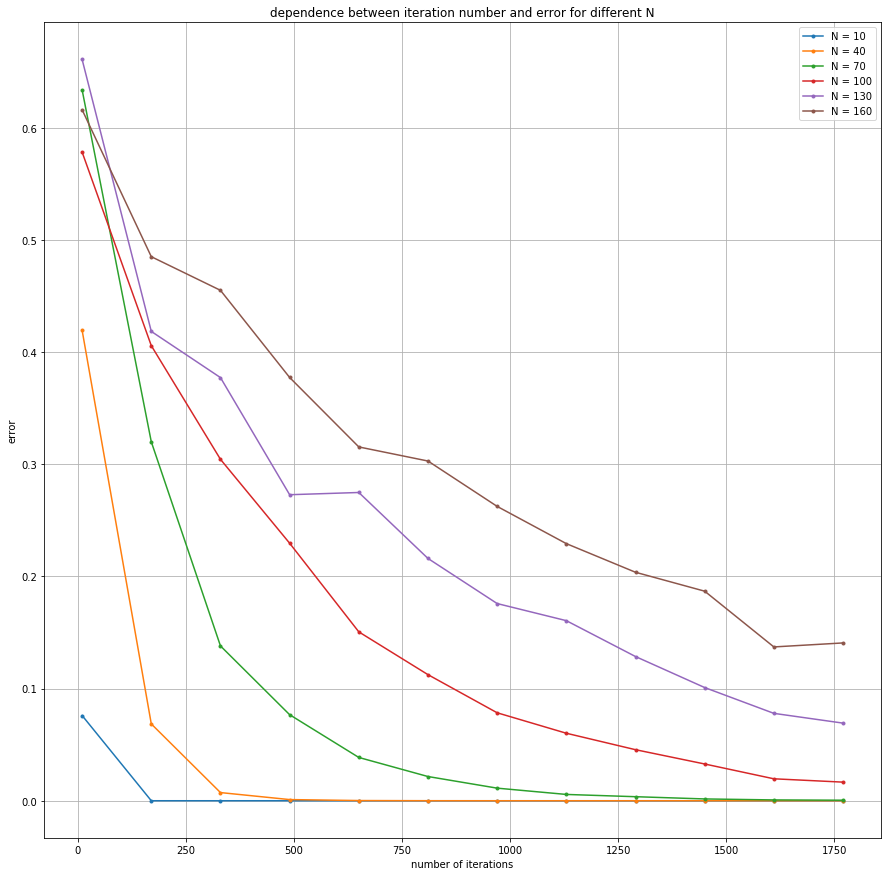

In [50]:
import warnings
warnings.filterwarnings("ignore")

iterations = np.arange(num_iteration_min, num_iteration_max, num_iteration_step)

plt.figure(figsize=(15, 15))
plt.title("dependence between iteration number and error for different N")
plt.xlabel("number of iterations")
plt.ylabel("error")


lines = [plt.plot(iterations, data[key], ".-", label="N = " + str(key)) for key in data.keys()]

plt.legend(lines)
ax = plt.subplot(111)
ax.legend()
plt.grid()


plt.show()

Скорость уменьшения погрешности, как видно из графика, уменьшается с увеличением размерности матрицы.

То есть, с ростом $N$ скорость сходимости уменьшается.

## Соберем данные для нахождения зависимости погрешности решения от номера итерации для нескольких значений  𝜔

In [46]:
def num_iteration_dependence_omega(omegas: List[float],
                                   num_iteration_min: int, 
                                   num_iteration_max: int, 
                                   num_iteration_step: int) -> dict:
    result = {}
    n = 100
    for omega in omegas:
        errors = []
        for num_iteration in range(num_iteration_min, num_iteration_max, num_iteration_step):
            errors.append(get_error(differential_equation_solver_lu(n),
                                    differential_equation_solver_sor(n, omega, num_iteration)))
        result[omega] = errors
    
    return result

omega = [1, 1.3, 1.6, 1.8, 1.9]
num_iteration_min, num_iteration_max, num_iteration_step = 10, 1811, 160

data = num_iteration_dependence_omega(omega, 
                                      num_iteration_min, num_iteration_max, num_iteration_step)

## Нарисуем графики полученных зависимостей: 𝜔

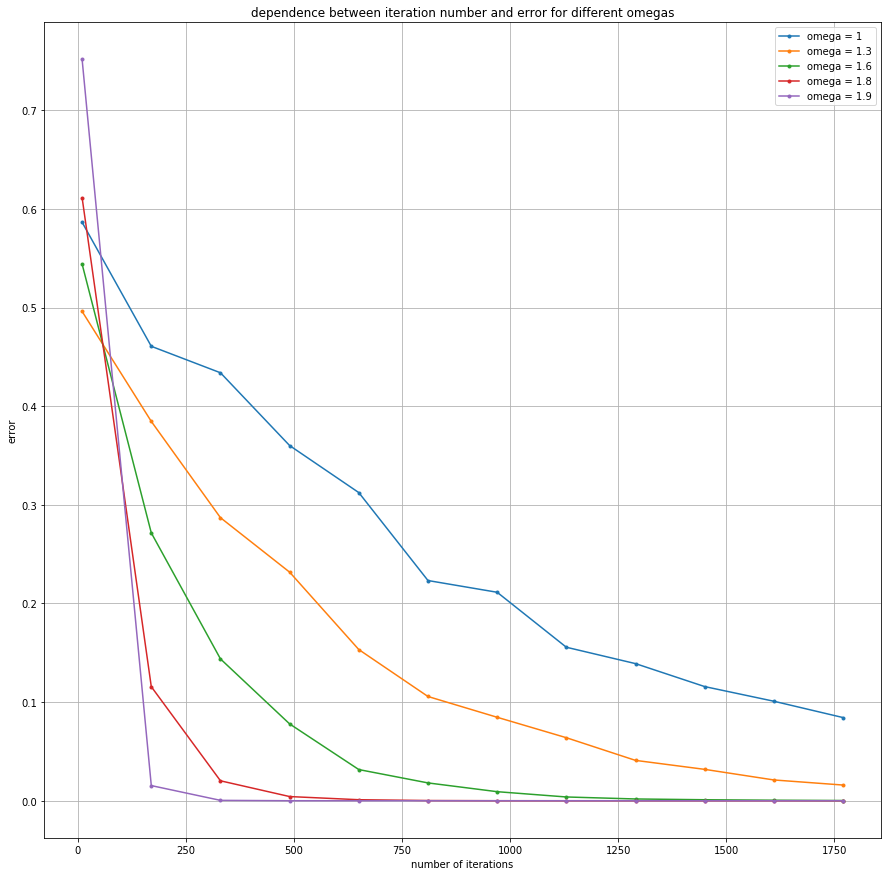

In [47]:
iterations = np.arange(num_iteration_min, num_iteration_max, num_iteration_step)

plt.figure(figsize=(15, 15))
plt.title("dependence between iteration number and error for different omegas")
plt.xlabel("number of iterations")
plt.ylabel("error")


lines = [plt.plot(iterations, data[key], ".-", label="omega = " + str(key)) for key in data.keys()]

plt.legend(lines)
ax = plt.subplot(111)
ax.legend()
plt.grid()


plt.show()

Скорость уменьшения погрешности, как видно из графика, как видно по уровню наклона кривых, увеличивается с уменьшением $\omega$.

То есть, чем меньше $\omega$, тем скорость сходимости больше.

### При $\omega=1$ достигается лучшая скорость сходимости